In [1]:
import warnings
import keplergl
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
import plotly.express as px
from skgstat import Variogram
import matplotlib.pyplot as plt
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import NearestNDInterpolator
from tobler.area_weighted import area_interpolate
import plotly.express as px
import json
import ogr
import ipywidgets as widgets

In [2]:
import altair as alt

# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [3]:
# ttm for all 3 days
days = pd.read_csv('all_days_ttm.csv')
days.head()

,fromId,type,hour,day,time_to_nearest1
0,59150004004,gallery,07:00,Friday,34
1,59150004004,gallery,07:00,Saturday,38
2,59150004004,gallery,07:00,Sunday,37
3,59150004004,gallery,08:00,Friday,38
4,59150004004,gallery,08:00,Saturday,37


In [44]:
# vancouver dissemination blocks
van = pd.read_csv("vancouver_db.csv")
van.replace(',','', regex=True, inplace=True)
van['pop'] = van['pop'].astype(str).astype(int)
van = van[['id', 'subdiv', 'pop']]

van.head()

,id,subdiv,pop
0,59150004004,West Vancouver,35
1,59150004005,West Vancouver,50
2,59150004006,West Vancouver,94
3,59150004011,West Vancouver,0
4,59150004012,West Vancouver,0


In [47]:
# get population for each city
df_popu = van.groupby(['subdiv'], as_index=False).sum()
df_popu = df_popu[['subdiv', 'pop']]
df_popu.columns = ['city', 'pop']
df_popu.head()

,city,pop
0,Anmore,2210
1,Barnston Island 3,49
2,Belcarra,643
3,Bowen Island,3680
4,Burnaby,232755


In [46]:
# merge 2 dataframes
van_day = pd.merge(days, van, left_on='fromId', right_on='id', how='inner').drop('id', axis=1)
van_day = van_day[['type', 'hour', 'day', 'time_to_nearest1', 'subdiv']]
van_day.head()

,type,hour,day,time_to_nearest1,subdiv
0,gallery,07:00,Friday,34,West Vancouver
1,gallery,07:00,Saturday,38,West Vancouver
2,gallery,07:00,Sunday,37,West Vancouver
3,gallery,08:00,Friday,38,West Vancouver
4,gallery,08:00,Saturday,37,West Vancouver


In [48]:
# get average travel time to the nearest amenity
df = van_day.groupby(['subdiv', 'day', 'hour'], as_index=False).mean()
df = df[['subdiv','day','hour','time_to_nearest1']]
df.head()

,subdiv,day,hour,time_to_nearest1
0,Anmore,Friday,07:00,56.31250
1,Anmore,Friday,08:00,57.53125
2,Anmore,Friday,09:00,55.53125
3,Anmore,Friday,10:00,55.46875
4,Anmore,Friday,11:00,52.90625


In [49]:
# merge with population info for each city
van_popu = pd.merge(df, df_popu, left_on='subdiv', right_on='city', how='inner').drop('city', axis=1)
van_popu.head()

,subdiv,day,hour,time_to_nearest1,pop
0,Anmore,Friday,07:00,56.31250,2210
1,Anmore,Friday,08:00,57.53125,2210
2,Anmore,Friday,09:00,55.53125,2210
3,Anmore,Friday,10:00,55.46875,2210
4,Anmore,Friday,11:00,52.90625,2210


In [52]:
van_popu.subdiv.unique()

array(['Anmore', 'Belcarra', 'Bowen Island', 'Burnaby', 'Burrard Inlet 3',
       'Capilano 5', 'Coquitlam', 'Coquitlam 2', 'Delta',
       'Greater Vancouver A', 'Katzie 1', 'Langley', 'Lions Bay',
       'Maple Ridge', 'Mission 1', 'Musqueam 2', 'New Westminster',
       'North Vancouver', 'Pitt Meadows', 'Port Coquitlam', 'Port Moody',
       'Richmond', 'Semiahmoo', 'Seymour Creek 2', 'Surrey', 'Tsawwassen',
       'Vancouver', 'West Vancouver', 'White Rock', 'Whonnock 1'],
      dtype=object)

In [64]:
# remove areas are not in metro Vancouver
# van_list = ['Anmore', 'Belcarra', 'Bowen Island', 'Burnaby', 'Coquitlam', 'Delta', 'Langley', 'Lions Bay', 'Maple Ridge', 'New Westminster',
#        'North Vancouver', 'Pitt Meadows', 'Port Coquitlam', 'Port Moody', 'Richmond', 'Surrey', 'Tsawwassen', 'Vancouver', 'West Vancouver', 'White Rock']

not_list = ['Anmore', 'Belcarra','Bowen Island','Burrard Inlet 3','Lions Bay','Capilano 5', 'Coquitlam 2', 'Greater Vancouver A', 'Katzie 1', 'Mission 1', 
            'Musqueam 2', 'Semiahmoo', 'Seymour Creek 2','Tsawwassen', 'Whonnock 1']
van_popu = van_popu[~van_popu.subdiv.isin(not_list)]

### Note:
**Order of Colour legend** is based on **average travel time**, which is same as the order shown in the plot **from top to bottom**.

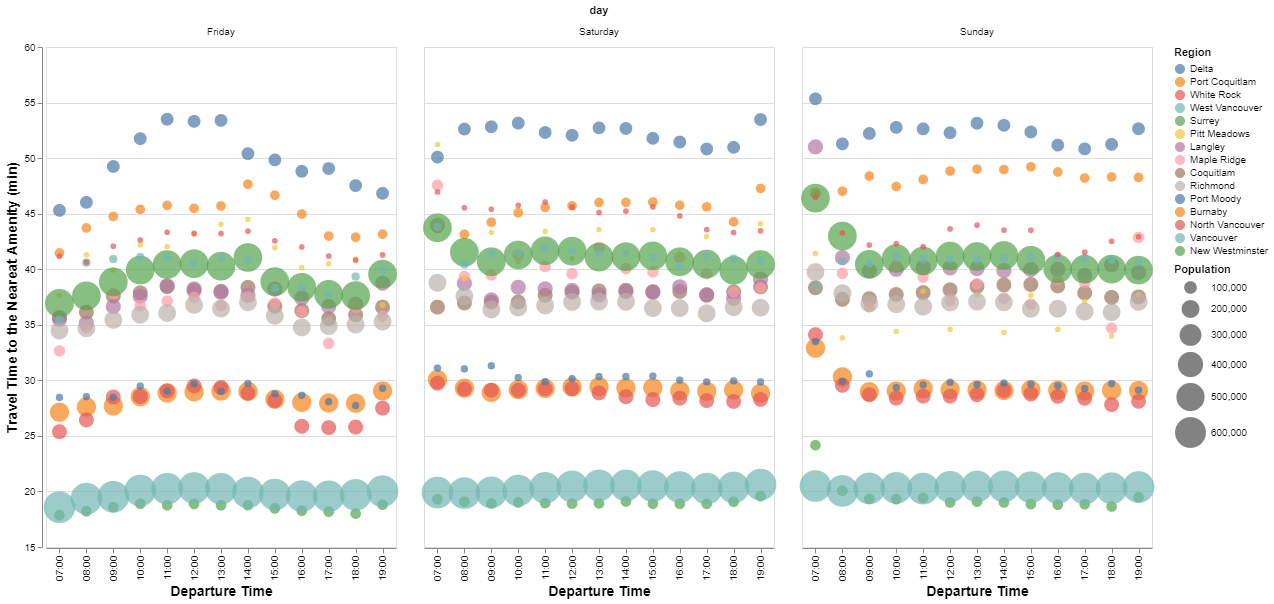

In [65]:

alt.Chart(van_popu, title='Changes of Travel Time to the Nearest Amenity').mark_circle().encode(
    alt.X('hour',
        scale=alt.Scale(zero=False), axis=alt.Axis(title='Departure Time')),
    alt.Y('time_to_nearest1',
        scale=alt.Scale(zero=False), axis=alt.Axis(title='Travel Time to the Neareat Amenity (min)')),
    color = alt.Color('subdiv', legend=alt.Legend(title='Region'), sort=alt.EncodingSortField('time_to_nearest1', op='mean', order='descending')),
    size = alt.Size('pop', scale=alt.Scale(range=[0, 1000]), legend=alt.Legend(title="Population"))
).properties(width=350, height=500
).facet('day', columns=3
).configure_axis(
    titleFontSize = 14
)